In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

In [2]:
def str2Date(str, start = True):
    if start:
        day = 1
        month = 1
    else:
        day = 31
        month = 12
    strParser = str.split('/')
    if (strParser[0] != ''):
        day = int(strParser[0])
    if (strParser[1] != ''):
        month = int(strParser[1])
    year = int(strParser[2])
    
    if start == False and day == 31:
        if month == 2:
            day = 28
        elif month in [4, 6, 9, 11]:
            day = 30
    return {'day': day, 'month': month, 'year': year}

In [3]:
df = pd.read_csv('EMDAT_Indochina.csv', sep=',', encoding='ISO-8859-1',header=1)

In [4]:
vnDf = df[df['Country'] == 'Viet Nam']

In [5]:
def dropDuplicateProvince(shapefile):
    if 'CCA_1' in shapefile.T.index:
        a = shapefile[shapefile['CCA_1'] == '0'].index
        shapefile = shapefile.drop(a)
        shapefile.reset_index(drop=True)
    return shapefile

In [6]:
def dropNullLocation(df):
    a = df[pd.isnull(df['Location'])].index
    return df.drop(a)

In [7]:
def normalizeStr(str, stripWord=True, removeParentheses=True):
    from unidecode import unidecode
    str = str.strip('\r\n')
    str = str.lower()
    norm_s = str.replace(' ', '')
    norm_s = norm_s.replace('-', '')
    norm_s = norm_s.replace('?', '')
    if stripWord:
        index = norm_s.find('city|')
        if index != -1:
            norm_s = norm_s[index+5:]
    if removeParentheses:
        if norm_s.find('(') >= 0: norm_s = norm_s[:norm_s.find('(')]
    norm_s
    norm_s = unidecode(norm_s)
    return norm_s

In [8]:
def createListProvince(shapefile, splitMultipleNames=False):
    list_province = shapefile['VARNAME_1'].tolist();
    for i in range(len(list_province)):
        if list_province[i] == None:
            list_province[i] = shapefile['NAME_1'].iloc[i]
    for i in range(len(list_province)):
        list_province[i] = normalizeStr(list_province[i])
        if splitMultipleNames:
            if list_province[i].find('|') != -1:
                list_province[i] = list_province[i].split('|')
    return list_province

In [9]:
def read_shapefile(shapefilePath):
    shapefile = gpd.read_file(shapefilePath)
    return dropDuplicateProvince(shapefile)

In [10]:
shapefileDir = '/home/lamductan/Hydroviet/github/DataNotebook/CountryShapefile'
vnShapefilePath = shapefileDir + '/vnShapefile/VNM_adm1.shp'
vnShapefile = read_shapefile(vnShapefilePath)
vn_list_province = createListProvince(vnShapefile)
print(vn_list_province)

['danang', 'dongnai', 'dongthap', 'dacnong', 'daklak|daclac', 'dienbien', 'angiang', 'bariavtau|bariavungtau', 'binhdinh', 'binhduong', 'binhphuoc', 'binhthuan', 'baclieu', 'bacgiang', 'backan|baccan', 'bacninh', 'bentre', 'camau', 'caobang', 'cantho', 'gialai', 'hagiang', 'hanoi', 'hanam', 'hatinh', 'hochiminh', 'hoabinh', 'hungyen', 'haiduong', 'haiphong', 'haugiang', 'khanhhoa', 'kiengiang', 'kontum', 'laocai', 'lamdong', 'laichau', 'langson', 'longan', 'namdinh', 'nghean', 'ninhbinh', 'ninhthuan', 'phutho', 'phuyen', 'quangbinh', 'quangnam', 'quangngai', 'quangninh', 'quangtri', 'soctrang', 'sonla', 'tayninh', 'thaibinh', 'thainguyen', 'thuathienhue', 'thanhhoa', 'tiengiang', 'travinh', 'tuyenquang', 'vinhlong', 'vinhphuc', 'yenbai']


In [11]:
def statByProvince(data, shapefile, yearStart, yearEnd):
    list_province_no_split = createListProvince(shapefile)
    list_province = createListProvince(shapefile, True)
    cnt = dict(zip(list_province_no_split, np.zeros(len(list_province_no_split)).astype(int)))
    for i in range(data.shape[0]):
        line = data.iloc[i]
        startDate = str2Date(line['Start date'])
        year = startDate['year']
        if (year >= yearStart and year <= yearEnd):
            s = line['Location'].replace(';', ',')
            locations = s.split(',')
            for i in range(len(locations)):
                locations[i] = normalizeStr(locations[i], False, False)

            for location in locations:
                if location == 'trang':
                    continue
                for key_value_tuple, province in zip(cnt.items(), list_province):
                    key = key_value_tuple[0]
                    if not isinstance(province, list):
                        if location in key or key in location:
                            cnt[key] += 1
                    else:
                        for p in province:
                            if location in p or p in location:
                                cnt[key] += 1
                                break
                                
    return cnt

In [12]:
def geo_heatmap(shapes, scores, ax=None, order=None, overlay=False, colormap='coolwarm', minv=0.0, maxv=1.0):

    from sklearn.preprocessing import minmax_scale
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt
    from matplotlib import ticker

    cm = plt.get_cmap(colormap)
    #scale = minmax_scale(scores)
    scale = scores
    minv = scores.min()
    maxv = scores.max()

    if ax is None:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111)

    mp = MultiPolygon(shapes)

    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for yield_diff, p in zip(scale, shapes):
        color = cm(yield_diff)
        if overlay:
            patches.append(PolygonPatch(p, fc='none', ec='#555555', zorder=1))
        else:
            patches.append(PolygonPatch(p, fc=color, ec='#555555', zorder=1))
    p = PatchCollection(patches, match_original=True, cmap=colormap)
    ax.add_collection(p)
    ax.axis('off')
    p.set_array(np.array(scale))
    if minv is None or maxv is None:
        minv = np.ma.min(scores)
        maxv = np.ma.max(scores)
    p.set_clim([minv, maxv])
    cb = plt.colorbar(p, shrink=0.5, ax=ax)
    tick_locator = ticker.MaxNLocator(nbins=max(min(10,maxv),2))
    cb.locator = tick_locator
    cb.update_ticks()
    
    #plt.show()
    
    return ax

In [13]:
def statAndVisualizeInYear(data, shapefile, year, ax=None):
    from shapely.geometry import Polygon, MultiPolygon, shape
    shapes = [shape(p) for p in shapefile['geometry']]
    
    country = data.iloc[0]['Country']
    from matplotlib import pyplot as plt
    import math
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(10,10))
    #fig.suptitle('Number of floods of {0} \'s provinces in {1}'.format(country, year), fontsize=20, fontweight='bold')

    stat = statByProvince(data, shapefile, year, year)
    scores = np.array(list(stat.values()), np.int)
    geo_heatmap(shapes, scores, ax=ax)
    ax.set_title('{0}'.format(year))

In [14]:
def visualizeByCountryAndYear(data, shapefile):       
    from ipywidgets import interact, interactive, fixed, interact_manual, Layout
    import ipywidgets as widgets
    %matplotlib inline
    sliderYears = widgets.IntSlider(value=2017, min=1980, max=2017, step=1, layout=Layout(width='100%'))
    interact(statAndVisualizeInYear, year=sliderYears, data=fixed(data), shapefile=fixed(shapefile), ax=fixed(None))

In [15]:
vnShapefilePath = shapefileDir + '/vnShapefile/VNM_adm1.shp'
vnShapefile = read_shapefile(vnShapefilePath)
vnDf = df[df['ISO'] == 'VNM']
floodVnDf = vnDf[vnDf['Disaster type'] == 'Flood']
floodVnDf = dropNullLocation(floodVnDf)
visualizeByCountryAndYear(floodVnDf, vnShapefile)

interactive(children=(IntSlider(value=2017, description='year', layout=Layout(width='100%'), max=2017, min=198…

In [16]:
laShapefilePath = shapefileDir + '/laShapefile/LAO_adm1.shp'
laShapefile = read_shapefile(laShapefilePath)

cbShapefilePath = shapefileDir + '/cbShapefile/KHM_adm1.shp'
cbShapefile = read_shapefile(cbShapefilePath)

tlShapefilePath = shapefileDir + '/tlShapefile/THA_adm1.shp'
tlShapefile = read_shapefile(tlShapefilePath)

mekongShapefile = vnShapefile.copy()
mekongShapefile = mekongShapefile.append(laShapefile)
mekongShapefile = mekongShapefile.append(cbShapefile)
mekongShapefile = mekongShapefile.append(tlShapefile)

floodMekongDf = df[df['Disaster type'] == 'Flood']
floodMekongDf['Country'].iloc[0] = 'Mekong'

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
visualizeByCountryAndYear(floodMekongDf, mekongShapefile)

interactive(children=(IntSlider(value=2017, description='year', layout=Layout(width='100%'), max=2017, min=198…

In [18]:
laShapefilePath = shapefileDir + '/laShapefile/LAO_adm1.shp'
laShapefile = read_shapefile(laShapefilePath)
laDf = df[df['ISO'] == 'LAO']
floodLaDf = laDf[laDf['Disaster type'] == 'Flood']
floodLaDf = dropNullLocation(floodLaDf)
visualizeByCountryAndYear(floodLaDf, laShapefile)

interactive(children=(IntSlider(value=2017, description='year', layout=Layout(width='100%'), max=2017, min=198…

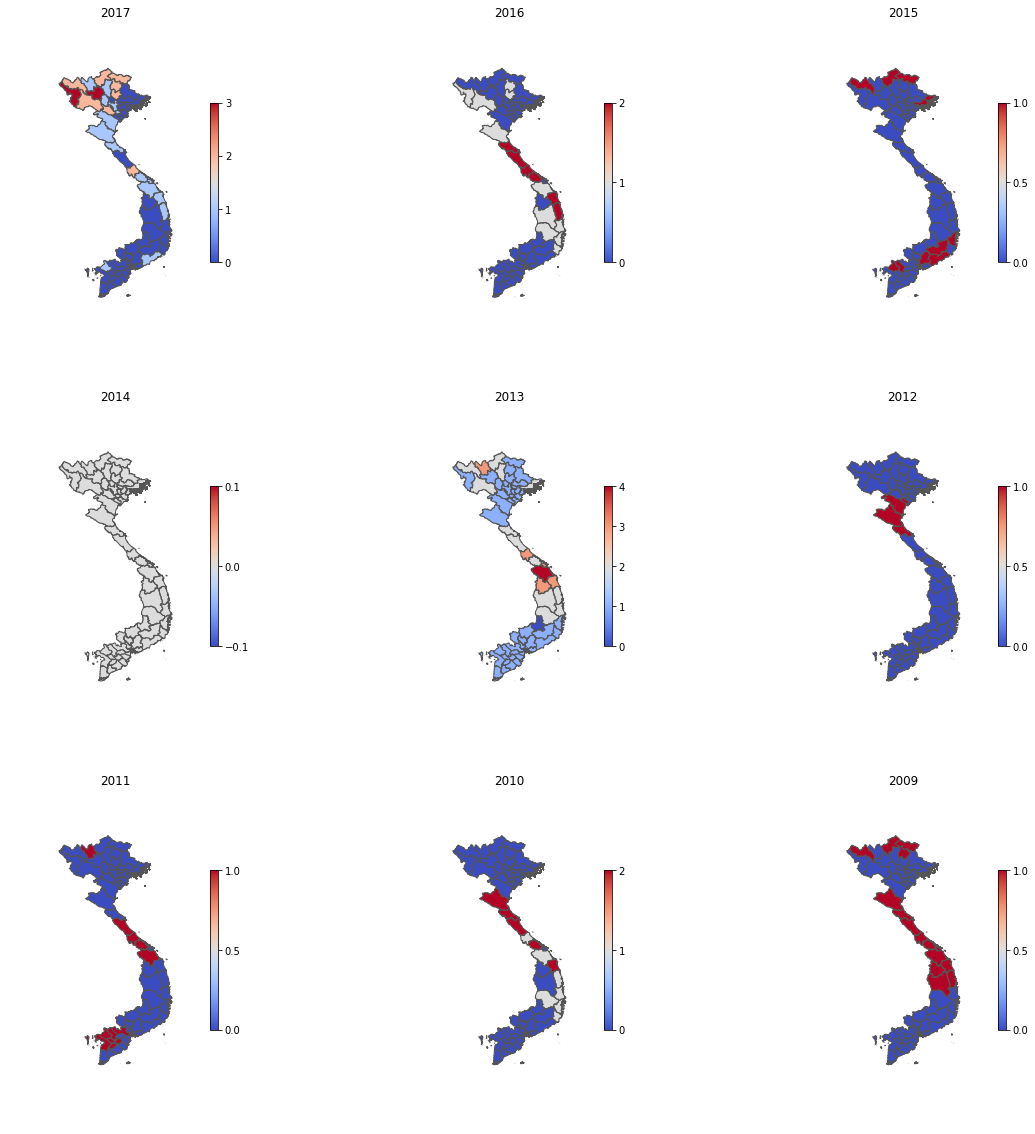

In [19]:
fig, axes = plt.subplots(3,3, figsize=(20,20))
for i in range(3):
    for j in range(3):
        year = 2017 - (j + 3*i)
        statAndVisualizeInYear(floodVnDf, vnShapefile, year, axes[i][j])

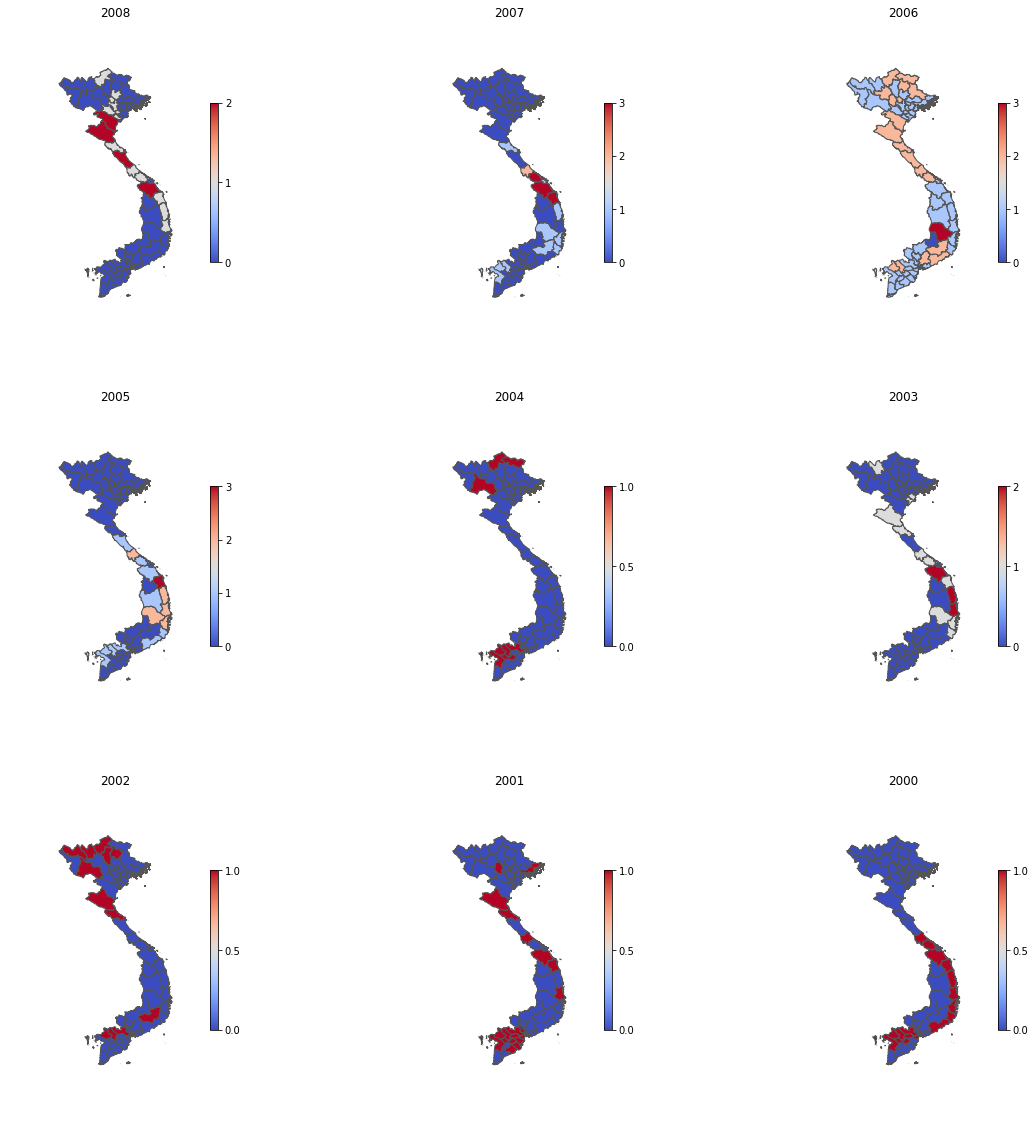

In [20]:
fig, axes = plt.subplots(3,3, figsize=(20,20))
for i in range(3):
    for j in range(3):
        year = 2008 - (j + 3*i)
        statAndVisualizeInYear(floodVnDf, vnShapefile, year, axes[i][j])

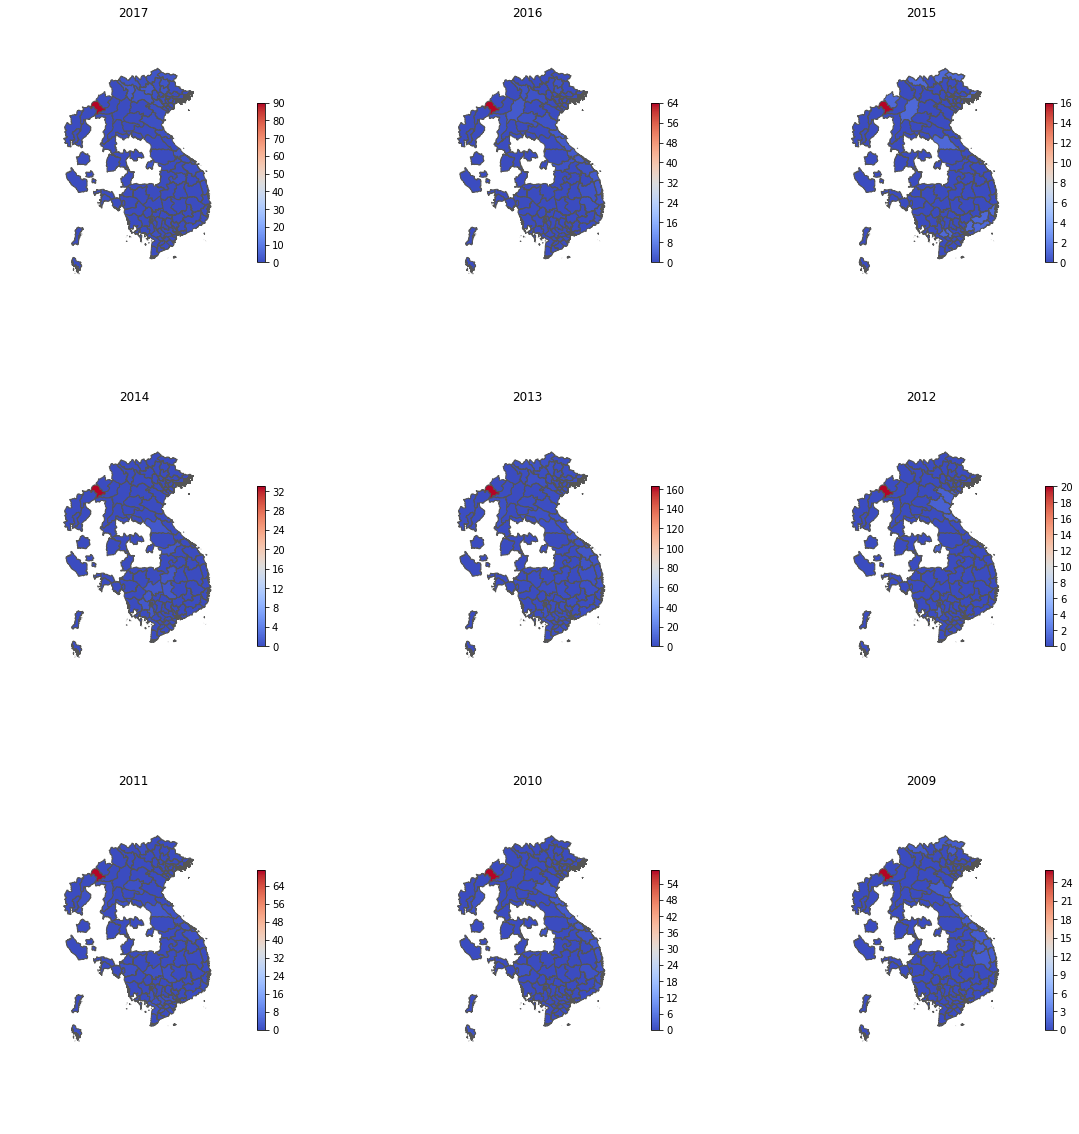

In [20]:
fig, axes = plt.subplots(3,3, figsize=(20,20))
for i in range(3):
    for j in range(3):
        year = 2017 - (j + 3*i)
        statAndVisualizeInYear(floodMekongDf, mekongShapefile, year, axes[i][j])

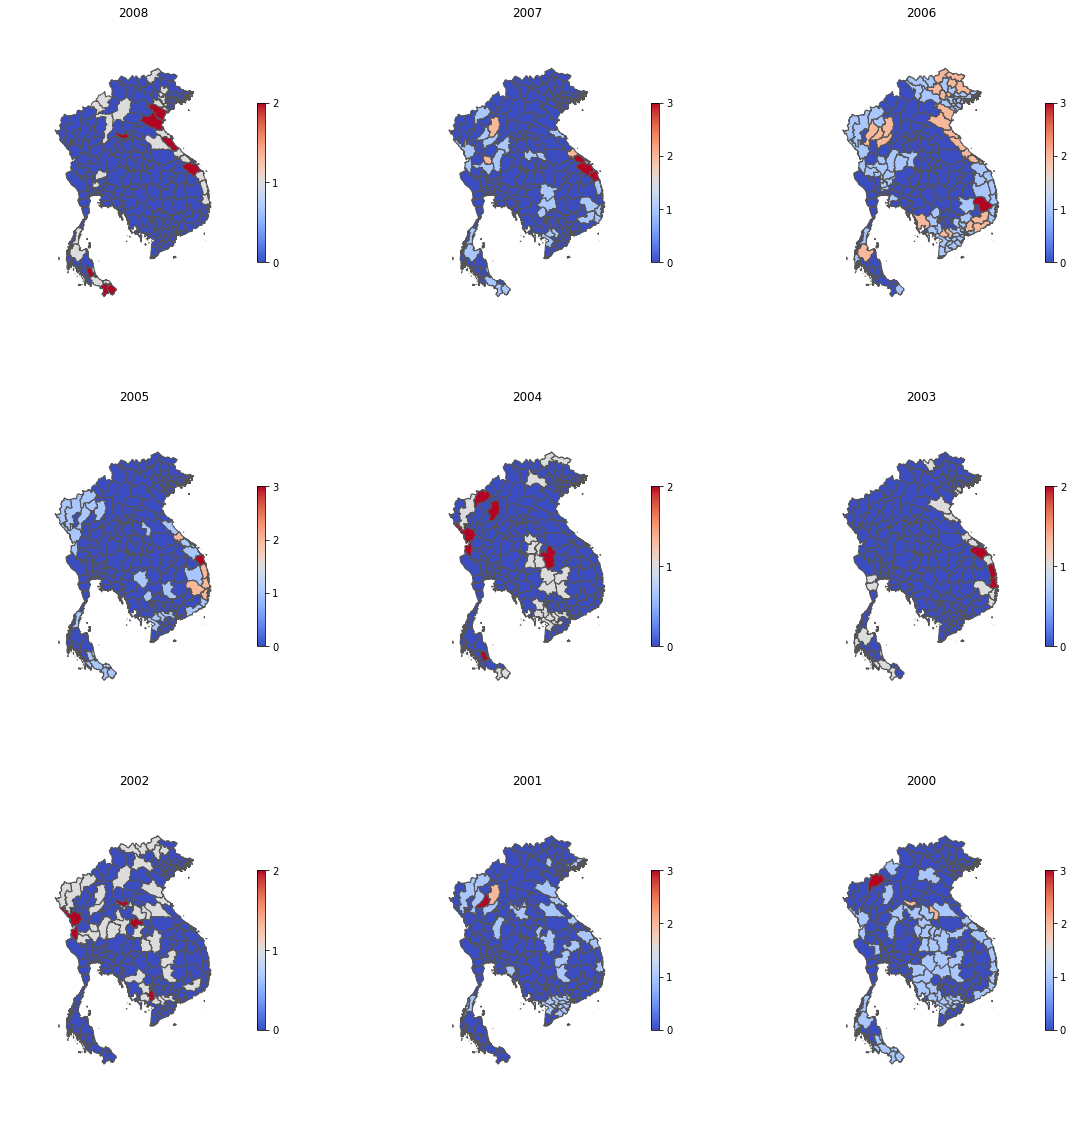

In [22]:
fig, axes = plt.subplots(3,3, figsize=(20,20))
for i in range(3):
    for j in range(3):
        year = 2008 - (j + 3*i)
        statAndVisualizeInYear(floodMekongDf, mekongShapefile, year, axes[i][j])

In [21]:
print(statByProvince(floodVnDf, vnShapefile, 2017, 2017))

{'danang': 1, 'dongnai': 0, 'dongthap': 0, 'dacnong': 0, 'daklak|daclac': 0, 'dienbien': 3, 'angiang': 1, 'bariavtau|bariavungtau': 0, 'binhdinh': 1, 'binhduong': 0, 'binhphuoc': 0, 'binhthuan': 1, 'baclieu': 0, 'bacgiang': 0, 'backan|baccan': 2, 'bacninh': 0, 'bentre': 0, 'camau': 0, 'caobang': 2, 'cantho': 0, 'gialai': 0, 'hagiang': 2, 'hanoi': 1, 'hanam': 1, 'hatinh': 1, 'hochiminh': 0, 'hoabinh': 2, 'hungyen': 0, 'haiduong': 0, 'haiphong': 0, 'haugiang': 0, 'khanhhoa': 0, 'kiengiang': 0, 'kontum': 0, 'laocai': 1, 'lamdong': 0, 'laichau': 2, 'langson': 0, 'longan': 0, 'namdinh': 0, 'nghean': 1, 'ninhbinh': 0, 'ninhthuan': 0, 'phutho': 1, 'phuyen': 0, 'quangbinh': 0, 'quangnam': 1, 'quangngai': 1, 'quangninh': 0, 'quangtri': 2, 'soctrang': 0, 'sonla': 2, 'tayninh': 0, 'thaibinh': 0, 'thainguyen': 2, 'thuathienhue': 1, 'thanhhoa': 1, 'tiengiang': 0, 'travinh': 0, 'tuyenquang': 1, 'vinhlong': 0, 'vinhphuc': 0, 'yenbai': 3}


In [22]:
def createListProvinceID(countryShapefile):
    listProvinceID = {}
    listProvince = createListProvince(countryShapefile, True)
    for i in range(len(listProvince)):
        if isinstance(listProvince[i], list):
            for provinceName in listProvince[i]:
                listProvinceID[provinceName] = i
        else:
            listProvinceID[listProvince[i]] = i
    return listProvinceID

In [23]:
def getGeometryDisaster(countryShapefile, strLocation, listProvinceID):
    from shapely.geometry import Polygon, MultiPolygon, shape
    s = strLocation.replace(';', ',')
    locations = s.split(',')
    
    for i in range(len(locations)):
        locations[i] = normalizeStr(locations[i], False, False)
    listPolygons = []
    
    for location in locations:
        if location in listProvinceID.keys():
            id = listProvinceID[location]
            provinceShape = countryShapefile.iloc[id]['geometry']
            if isinstance(provinceShape, MultiPolygon):
                listPolygons += provinceShape
            else:
                listPolygons.append(provinceShape)
        else:
            for province in listProvinceID:
                if location in province or province in location:
                    id = listProvinceID[province]
                    provinceShape = countryShapefile.iloc[id]['geometry']
                    if isinstance(provinceShape, MultiPolygon):
                        listPolygons += provinceShape
                    else:
                        listPolygons.append(provinceShape)
                    break
    
    if listPolygons == []:
        return np.nan
    else:
        return MultiPolygon(listPolygons)

In [24]:
countryShapefileDict = dict()
countryShapefileDict['VNM'] = vnShapefile
countryShapefileDict['THA'] = tlShapefile
countryShapefileDict['KHM'] = cbShapefile
countryShapefileDict['LAO'] = laShapefile

In [25]:
listProvinceIdDict = dict()
listISO = df['ISO'].unique()
for countryISO in listISO[:-1]:
    listProvinceIdDict[countryISO] = createListProvinceID(countryShapefileDict[countryISO])

In [26]:
geometry = []
df = pd.read_csv('EMDAT_Indochina.csv', sep=',', encoding='ISO-8859-1',header=1)
floodDf = df[df['Disaster type'] == 'Flood']

from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon, MultiPolygon
def createColumnGeometry(df, countryShapefileDict, listProvinceIdDict):
    for i in range(df.shape[0]):
        row = df.iloc[i]
        if not isinstance(row['Location'], str):
            geometry.append(Polygon([[1,1],[2,2],[1,2]]))
        else:
            countryISO = row['ISO']
            geometryInRow = getGeometryDisaster(countryShapefileDict[countryISO], row['Location'], listProvinceIdDict[countryISO])
            if isinstance(geometryInRow,MultiPolygon):
                geometry.append(geometryInRow)
            else:
                geometry.append(Polygon([[1,1],[2,2],[1,2]]))
    return geometry

geometry = createColumnGeometry(floodDf, countryShapefileDict, listProvinceIdDict)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(floodDf, crs=crs, geometry=geometry)

In [ ]:
gdf.to_file(driver = 'ESRI Shapefile', filename = "DisasterGeometry/DisasterGeometry.shp")

In [32]:
data = gpd.read_file('DisasterGeometry')

In [38]:
print(data)

     Start date    End date                                 Country  ISO  \
0    22/08/1991  30/08/1991                                Cambodia  KHM   
1    31/07/1994  31/07/1994                                Cambodia  KHM   
2    30/09/1996  03/11/1996                                Cambodia  KHM   
3    02/08/1999  08/08/1999                                Cambodia  KHM   
4    25/10/1999  09/11/1999                                Cambodia  KHM   
5    11/07/2000  10/08/2000                                Cambodia  KHM   
6    15/08/2001  19/11/2001                                Cambodia  KHM   
7    18/08/2002  26/11/2002                                Cambodia  KHM   
8    24/08/2004  21/10/2004                                Cambodia  KHM   
9    08/09/2005  29/09/2005                                Cambodia  KHM   
10   06/07/2006  07/07/2006                                Cambodia  KHM   
11   10/08/2006  01/11/2006                                Cambodia  KHM   
12   10/08/2